# Machine Learning project CS-433: NMR spectroscopy supervised learning



## Schedules:

* Week 10 (18-24 November): 
 * Tests of various linear models/simple NN on a 10% subset of data
* Week 11 (25-1 December):
 * Feature selection: being able to come with a good set of features
* Week 12 (2-8 December):
 * Start of big scale analysis with Spark, implementation of the models which perform well at small scale
* Week 13 (9-15 December):
 * Wrapping up
* Week 14 (16-22 December): 
 * 19th December: Deadline

In [130]:
import os
import re
import pickle
import scipy.stats
import sklearn.metrics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from itertools import combinations

from IPython.core.debugger import set_trace


from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [144]:
# For neural net part
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

## Log Book

We write here the log of the different techniques/improvements we add to the program: **cf log/models_log.txt** for the different models already tried and their results.

## Pipeline

In [2]:
#pipeline graph coming soon

In [3]:
tot_data_X = np.load('data/CSD-10k_H_fps_1k_MD_n_12_l_9_rc_3.0_gw_0.3_rsr_1.0_rss_2.5_rse_5.npy',mmap_mode='r')
tot_data_y = np.load('data/CSD-10k_H_chemical_shieldings.npy',mmap_mode='r')
DATA_LEN = tot_data_X.shape[0]
DATA_COLS = tot_data_X.shape[1]

In [4]:
def load_data(n_samples,tot_data_x = tot_data_X,tot_data_y = tot_data_y):
    #np.random.seed(14)
    mask_data = np.random.permutation(DATA_LEN)[:n_samples]

    data_X = tot_data_X[mask_data]
    data_y = tot_data_y[mask_data]
    return data_X, data_y

In [5]:
def load_data_train_test(n_samples,tot_data_x = tot_data_X,tot_data_y = tot_data_y):
    data_X, data_y = load_data(n_samples,tot_data_x,tot_data_y)
    X_train,X_test,y_train,y_test = train_test_split(data_X,data_y,test_size = 0.2)
    return X_train,X_test,y_train,y_test

## Data Vizualisation

In [6]:
data_X,data_y = load_data(3000)
data_X_df = pd.DataFrame(data_X)
data_y_df = pd.DataFrame(data_y)

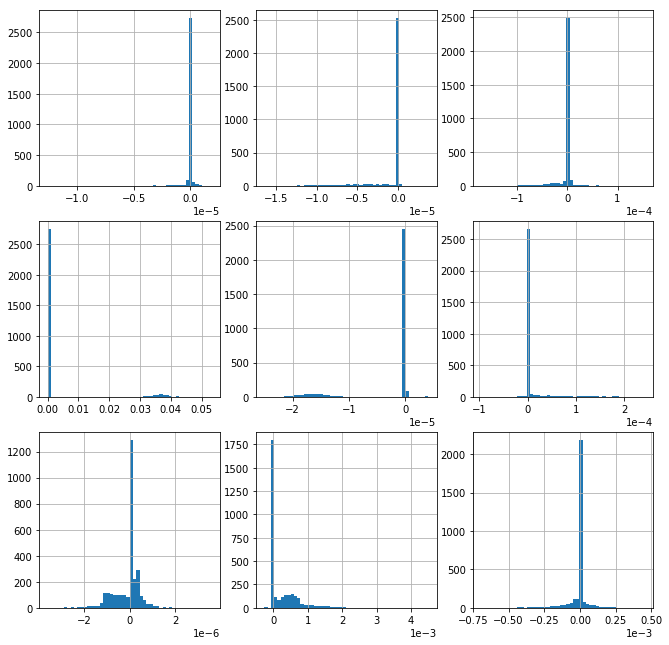

In [7]:
mask = np.random.permutation(DATA_COLS)[:9]
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(11,11)
for ind,i in enumerate(mask):
    index = np.unravel_index(ind,(3,3))
    axes[index].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    data_X_df.iloc[:,i].hist(ax = axes[index],bins = 50)
    #data_X_df.iloc[:,i].plot.box(ax = axes[index])

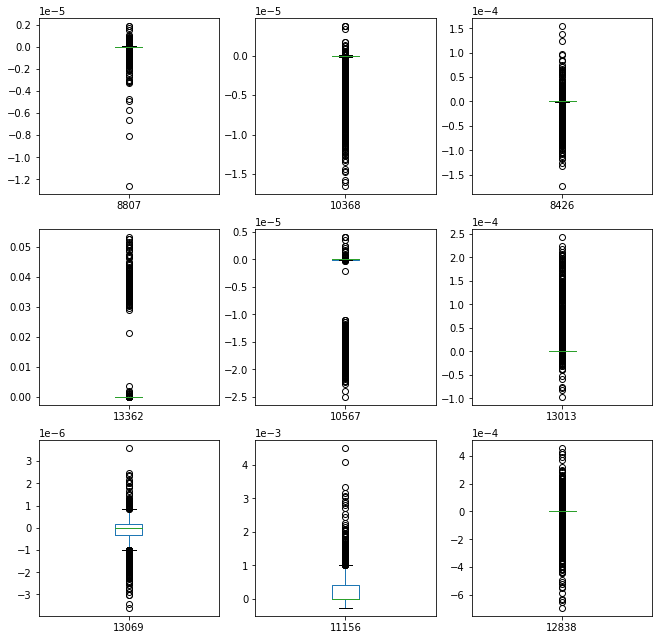

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(11,11)
for ind,i in enumerate(mask):
    index = np.unravel_index(ind,(3,3))
    axes[index].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
    #data_X_df.iloc[:,i].hist(ax = axes[index],bins = 50)
    data_X_df.iloc[:,i].plot.box(ax = axes[index])

We see that the different features are scaled pretty differently, we might want to scale them beforehand. Since they don' look like following a gaussian, we'll apply min/max scaling: but in order to do so, we first need to get rid of the outliers thanks to one of the following methods
* Zscore: not adapted as our data might not be gaussian
* DBScan:
* Isolation Forest:

## Outliers detection

In [9]:
def filter_outliers(meth,X_train,y_train):
    """
    Drops the outliers values from the dataset
    masks: [[int]]: each array's indexes correspond to the samples that the corresponding feature considers as outliers.
    """
    masks = np.array([meth(feat) for feat in X_train.T])
    masks = np.hstack(masks)
   # set_trace()
    X_train = np.delete(X_train,masks,axis = 0)
    y_train = np.delete(y_train,masks,axis = 0)
    return X_train,y_train

### DBSCAN

Problem: computationally too demanding.

In [ ]:
#clustering = DBSCAN(eps=0.3, min_samples=2).fit(X_train)
#with np.printoptions(threshold=np.inf):
#    print(clustering.labels_)

### Interquartile range method (IQR)

Consists in considering as outliers all data points that lie in >1.5 interquartile range from the quartiles.

In [10]:
def IQR(ys):
    """
    returns the array of indexes of the samples considered as outliers according to IQR"""
    q1, q3 = np.percentile(ys, [5, 95])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

## Scaling

### Min/max Scaling

In [11]:
def apply_scaler(scaler,X_train,X_test):
    X_train = minmx_scaler.fit_transform(X_train)
    X_test = minmx_scaler.transform(X_test)
    return X_train,X_test

## Dimensionality reduction

### PCA

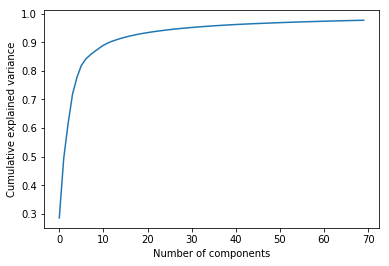

In [12]:
def plot_PCA(n_comp,X_train):
    """
    displays the 'elbow' of the PCA, ie the screeplot"""
    pca = PCA(n_components = n_comp)
    pca.fit(X_train)
    plt.figure(1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    
X_train,_,_,_ = load_data_train_test(3000)
plot_PCA(70,X_train)

In [13]:
def do_PCA(X_train,X_test,n):
    pca = PCA(n_components = n)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return X_train,X_test

## Models

### Linear Models

In [105]:
def test_lin_model(reg, X_train,y_train,X_test,y_test):
    """
    Test a model reg which is expected to be already instantiated
    return score_train,score_test"""
    reg.fit(X_train,y_train)
    train_R2 = reg.score(X_train,y_train)
    test_R2 = reg.score(X_test,y_test)
    y_hat = reg.predict(X_test)
    mse = mean_squared_error(y_test,y_hat)
    mae = mean_absolute_error(y_test,y_hat)
    print("Obtained score on train set %2.2f " % train_R2)
    print("Obtained score on test set %2.2f " % test_R2)
    print("Obtained MSE on test set %2.2f " % mse)
    print("Obtained MAE on test set %2.2f " % mae)
    return mse, mae

### Neural Nets

In [86]:
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n,100)
        #self.fc2 = nn.Linear(80,50)
        #self.fc3 = nn.Linear(624,624)
        self.fc4 = nn.Linear(100,1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [92]:
def train_model(model, train_input, train_target, mini_batch_size, monitor_loss=False):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-3) 
    nb_epochs = 100
    
    # Monitor loss
    losses = []
    
    for e in range(nb_epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            
            sum_loss += loss.item() # compute loss for each mini batch for 1 epoch
            
            optimizer.step()
        
        # Monitor loss
        losses.append(sum_loss)
        
        print('[epoch {:d}] loss: {:0.2f}'.format(e+1, sum_loss))
    
    if monitor_loss:
        return losses

In [25]:
def make_pred(model, data_input):
    y_hat = model(data_input)
    return y_hat

In [108]:
def compute_score(y_actual, y_pred):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    print("Obtained MSE on test set %2.2f " % mse)
    print("Obtained MAE on test set %2.2f " % mae)
    return mse, mae

## Main

Each cell here is meant to do a whole pipeline, from loading a certain number of samples, preprocessing etc. We keep using the R2 score as our metric

In [18]:
X_train_save,X_test_save,y_train_save,y_test_save = load_data_train_test(10000)

In [17]:
#Linear Regression
X_train = np.copy(X_train_save)
X_test = np.copy(X_test_save)
y_train = np.copy(y_train_save) # y_train?
y_test = np.copy(y_test_save)
X_train,y_train = filter_outliers(IQR,X_train,y_train)
X_train,X_test = do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)
lin = LinearRegression(fit_intercept = True).fit(X_train,y_train)
train_score,test_score = test_lin_model(lin,X_train,y_train,X_test,y_test)

Obtained score on train set 0.81 
Obtained score on test set 0.50 
Obtained MSE on test set 6.45 
Obtained MAE on test set 1.47 


In [18]:
#Ridge regression
X_train = np.copy(X_train_save)
X_test = np.copy(X_test_save)
y_train = np.copy(y_train_save)
y_test = np.copy(y_test_save)
do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)
rid = Ridge()#.fit(X_train,y_train)
train_score,test_score = test_lin_model(rid,X_train,y_train,X_test,y_test)

Obtained score on train set 0.96 
Obtained score on test set 0.93 
Obtained MSE on test set 0.84 
Obtained MAE on test set 0.69 


In [107]:
#Kernel ridge
X_train = np.copy(X_train_save)
X_test = np.copy(X_test_save)
y_train = np.copy(y_train_save)
y_test = np.copy(y_test_save)
X_train, X_test = do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)

kr = KernelRidge(alpha=0.1) #.fit(X_train,y_train)
train_score,test_score = test_lin_model(kr, X_train, y_train, X_test, y_test)

Obtained score on train set 0.72 
Obtained score on test set 0.73 
Obtained MSE on test set 3.28 
Obtained MAE on test set 1.36 


In [109]:
#Neural nets
#Get the data
X_train = np.copy(X_train_save)
X_test = np.copy(X_test_save)
y_train = np.copy(y_train_save)
y_test = np.copy(y_test_save)
X_train, X_test = do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)

#Convert to tensors
train_input = torch.Tensor(X_train)
test_input = torch.Tensor(X_test)
train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
test_target = torch.Tensor(y_test.reshape(len(y_test), 1))

In [110]:
# Sanity check
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([8000, 40])
torch.Size([8000, 1])
torch.Size([2000, 40])
torch.Size([2000, 1])


In [111]:
#Train model
mini_batch_size = 10
model = Net(40)
losses = train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

[epoch 1] loss: 55318.48
[epoch 2] loss: 5329.80
[epoch 3] loss: 3597.19
[epoch 4] loss: 2959.29
[epoch 5] loss: 2656.66
[epoch 6] loss: 2454.35
[epoch 7] loss: 2286.95
[epoch 8] loss: 2138.95
[epoch 9] loss: 2006.82
[epoch 10] loss: 1891.11
[epoch 11] loss: 1793.27
[epoch 12] loss: 1710.56
[epoch 13] loss: 1643.37
[epoch 14] loss: 1589.62
[epoch 15] loss: 1544.39
[epoch 16] loss: 1507.85
[epoch 17] loss: 1478.62
[epoch 18] loss: 1453.89
[epoch 19] loss: 1434.02
[epoch 20] loss: 1417.00
[epoch 21] loss: 1401.13
[epoch 22] loss: 1387.85
[epoch 23] loss: 1377.06
[epoch 24] loss: 1367.08
[epoch 25] loss: 1357.13
[epoch 26] loss: 1349.30
[epoch 27] loss: 1338.05
[epoch 28] loss: 1334.49
[epoch 29] loss: 1327.57
[epoch 30] loss: 1321.26
[epoch 31] loss: 1315.00
[epoch 32] loss: 1308.74
[epoch 33] loss: 1302.71
[epoch 34] loss: 1297.86
[epoch 35] loss: 1290.93
[epoch 36] loss: 1287.77
[epoch 37] loss: 1279.65
[epoch 38] loss: 1275.64
[epoch 39] loss: 1272.27
[epoch 40] loss: 1266.22
[epoch 4

In [112]:
#Make predictions
y_hat = make_pred(model, test_input)

#Compute score
mse_nn, mae_nn = compute_score(y_test, y_hat.detach().numpy())

Obtained MSE on test set 1.15 
Obtained MAE on test set 0.79 


Text(0.5, 1.0, 'Loss evolution during training')

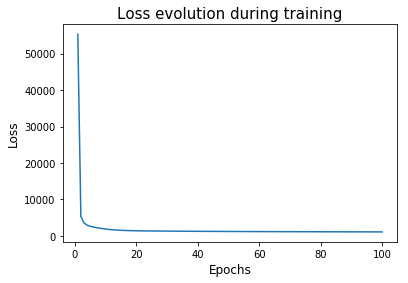

In [113]:
plt.plot(np.arange(100)+1, losses)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss evolution during training', fontsize=15)

In [125]:
#Random forest regressor
X_train = np.copy(X_train_save)
X_test = np.copy(X_test_save)
y_train = np.copy(y_train_save)
y_test = np.copy(y_test_save)
X_train, X_test = do_PCA(X_train,X_test,40)
minmx_scaler = MinMaxScaler()
X_train, X_test = apply_scaler(minmx_scaler,X_train,X_test)

rf = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=150)
train_score,test_score = test_lin_model(rf, X_train, y_train, X_test, y_test)

Obtained score on train set 0.97 
Obtained score on test set 0.89 
Obtained MSE on test set 1.32 
Obtained MAE on test set 0.84 


Text(0.5, 1.0, 'Feature importance')

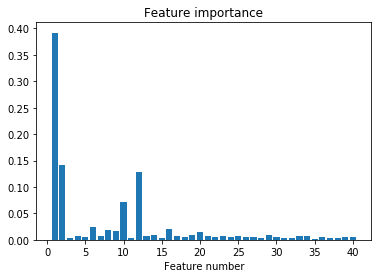

In [129]:
plt.bar(np.arange(40)+1, rf.feature_importances_)
plt.xlabel('Feature number')
plt.ylabel('')
plt.title('Feature importance')

#### ANN

In [148]:
# architecture 1
mlp_1 = Sequential()

mlp_1.add(Dense(100, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))
mlp_1.add(Dense(1, kernel_initializer='normal',activation='linear'))

mlp_1.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
mlp_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 4,201
Trainable params: 4,201
Non-trainable params: 0
_________________________________________________________________


In [149]:
# architecture 2
mlp_2 = Sequential()

# The Input Layer
mlp_2.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))
mlp_2.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer
mlp_2.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network
mlp_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
mlp_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               5248      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total params: 170,113
Trainable params: 170,113
Non-trainable params: 0
_________________________________________________________________


In [136]:
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
#callbacks_list = [checkpoint]

In [152]:
ann_model = mlp_2
ann_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split = 0.2) #callbacks=callbacks_list)

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 2s 371us/step - loss: 0.8087 - mean_absolute_error: 0.8087 - val_loss: 0.9989 - val_mean_absolute_error: 0.9989
Epoch 2/100
6400/6400 [==============================] - 3s 415us/step - loss: 0.7961 - mean_absolute_error: 0.7961 - val_loss: 0.7988 - val_mean_absolute_error: 0.7988
Epoch 3/100
6400/6400 [==============================] - 3s 445us/step - loss: 0.7940 - mean_absolute_error: 0.7940 - val_loss: 0.9229 - val_mean_absolute_error: 0.9229
Epoch 4/100
6400/6400 [==============================] - 3s 461us/step - loss: 0.8032 - mean_absolute_error: 0.8032 - val_loss: 0.7896 - val_mean_absolute_error: 0.7896
Epoch 5/100
6400/6400 [==============================] - 3s 421us/step - loss: 0.7962 - mean_absolute_error: 0.7962 - val_loss: 0.8451 - val_mean_absolute_error: 0.8451
Epoch 6/100
6400/6400 [==============================] - 3s 438us/step - loss: 0.7826 - mean_absolute_error

In [153]:
#Test model
y_hat = ann_model.predict(X_test)

#Compute score
mse_nn, mae_nn = compute_score(y_test, y_hat)

Obtained MSE on test set 1.03 
Obtained MAE on test set 0.75 
